In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import chardet
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from matplotlib import pyplot as plt

In [46]:
#Определим какой декодер использовать при открытии файла

file = r'C:\Users\aksen\PycharmProjects\pythonProject\data\property_info.csv'

with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'windows-1251', 'confidence': 0.99, 'language': 'Russian'}

In [47]:
#Загружаем дадасет

df = pd.read_csv(file, encoding='windows-1251')
df

,price,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building,repair_type,bathroom_type,material_type,year_build,flat_type,balcony_type
0,3300000.0,1.0,30.0,18.0,6.0,3.0,5.0,в хорошем состоянии,совмещенный,панель,1974.0,вторичное,"балкон, остекление"
1,8500000.0,2.0,58.7,NaN,NaN,6.0,19.0,в отличном состоянии,раздельный,кирпич,2020.0,вторичное,балкон
2,2000000.0,1.0,13.0,NaN,NaN,1.0,5.0,NaN,совмещенный,панель,1980.0,вторичное,NaN
3,8100000.0,2.0,63.5,31.8,9.4,3.0,10.0,в хорошем состоянии,совмещенный,кирпич,2007.0,вторичное,"балкон и лоджия, остекление"
4,6600000.0,2.0,60.0,35.0,25.0,NaN,NaN,в отличном состоянии,совмещенный,кирпич,1963.0,вторичное,"балкон, остекление"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,2100000.0,2.0,27.0,24.0,NaN,6.0,9.0,в отличном состоянии,NaN,кирпич,1988.0,вторичное,NaN
5212,1600000.0,2.0,37.7,NaN,NaN,5.0,5.0,в хорошем состоянии,совмещенный,панель,NaN,вторичное,балкон
5213,570000.0,3.0,64.0,NaN,NaN,1.0,1.0,требуется ремонт,NaN,дерево,NaN,вторичное,NaN
5214,4850000.0,3.0,58.0,41.0,5.0,5.0,5.0,в хорошем состоянии,раздельный,панель,1972.0,вторичное,балкон


In [48]:
#Исследуем данные

print(f'В исходном датасете {df.shape[0]} строк и {df.shape[1]} столбцов')

В исходном датасете 5216 строк и 13 столбцов


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               5216 non-null   float64
 1   rooms               5213 non-null   float64
 2   full_area           5213 non-null   float64
 3   living_area         1799 non-null   float64
 4   kitchen_area        2959 non-null   float64
 5   floor_number        4701 non-null   float64
 6   floors_in_building  4701 non-null   float64
 7   repair_type         4700 non-null   object 
 8   bathroom_type       4739 non-null   object 
 9   material_type       5158 non-null   object 
 10  year_build          4418 non-null   float64
 11  flat_type           5213 non-null   object 
 12  balcony_type        3639 non-null   object 
dtypes: float64(8), object(5)
memory usage: 529.9+ KB


In [50]:
#Пропущенные значения

for column in df.columns:
    print(f'Пропуски в колонке {column} составляют {round(df[column].isna().sum()/df.shape[0]*100,2)} %')

Пропуски в колонке price составляют 0.0 %
Пропуски в колонке rooms составляют 0.06 %
Пропуски в колонке full_area составляют 0.06 %
Пропуски в колонке living_area составляют 65.51 %
Пропуски в колонке kitchen_area составляют 43.27 %
Пропуски в колонке floor_number составляют 9.87 %
Пропуски в колонке floors_in_building составляют 9.87 %
Пропуски в колонке repair_type составляют 9.89 %
Пропуски в колонке bathroom_type составляют 9.14 %
Пропуски в колонке material_type составляют 1.11 %
Пропуски в колонке year_build составляют 15.3 %
Пропуски в колонке flat_type составляют 0.06 %
Пропуски в колонке balcony_type составляют 30.23 %


In [51]:
#Нулевые значения с категориальных признаках заменим на unknown
df[[
 'repair_type',
 'bathroom_type',
 'material_type',
 'flat_type',
 'balcony_type']] = df[[
 'repair_type',
 'bathroom_type',
 'material_type',
 'flat_type',
 'balcony_type']].fillna('unknown')

In [52]:
li = [name for name in df.columns]
li

['price',
 'rooms',
 'full_area',
 'living_area',
 'kitchen_area',
 'floor_number',
 'floors_in_building',
 'repair_type',
 'bathroom_type',
 'material_type',
 'year_build',
 'flat_type',
 'balcony_type']

In [53]:
#Делаем копию датасета с пропущенными численными признаками. Заполняем пропущенные значения с KNNInputer
df_2 = df[[
    'rooms',
 'full_area',
 'living_area',
 'kitchen_area',
'floor_number',
 'floors_in_building']]
imputer = KNNImputer(n_neighbors=3, weights='distance')
new_df = imputer.fit_transform(df_2)

In [54]:
new_df = pd.DataFrame(new_df)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5216 non-null   float64
 1   1       5216 non-null   float64
 2   2       5216 non-null   float64
 3   3       5216 non-null   float64
 4   4       5216 non-null   float64
 5   5       5216 non-null   float64
dtypes: float64(6)
memory usage: 244.6 KB


In [55]:
dataset = pd.concat((df[['price', 'repair_type','bathroom_type','material_type','flat_type','balcony_type']], new_df), axis=1)
dataset = dataset.rename(columns={0:'rooms', 1:'full_area', 2:'living_area', 3:'kitchen_area', 4:'floor_number', 5:'floors_in_building'})
dataset

,price,repair_type,bathroom_type,material_type,flat_type,balcony_type,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building
0,3300000.0,в хорошем состоянии,совмещенный,панель,вторичное,"балкон, остекление",1.0,30.0,18.000000,6.000000,3.0,5.0
1,8500000.0,в отличном состоянии,раздельный,кирпич,вторичное,балкон,2.0,58.7,49.940000,11.261538,6.0,19.0
2,2000000.0,unknown,совмещенный,панель,вторичное,unknown,1.0,13.0,11.500000,4.000000,1.0,5.0
3,8100000.0,в хорошем состоянии,совмещенный,кирпич,вторичное,"балкон и лоджия, остекление",2.0,63.5,31.800000,9.400000,3.0,10.0
4,6600000.0,в отличном состоянии,совмещенный,кирпич,вторичное,"балкон, остекление",2.0,60.0,35.000000,25.000000,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5211,2100000.0,в отличном состоянии,unknown,кирпич,вторичное,unknown,2.0,27.0,24.000000,6.729942,6.0,9.0
5212,1600000.0,в хорошем состоянии,совмещенный,панель,вторичное,балкон,2.0,37.7,25.375146,5.000000,5.0,5.0
5213,570000.0,требуется ремонт,unknown,дерево,вторичное,unknown,3.0,64.0,43.216667,14.000000,1.0,1.0
5214,4850000.0,в хорошем состоянии,раздельный,панель,вторичное,балкон,3.0,58.0,41.000000,5.000000,5.0,5.0


In [56]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               5216 non-null   float64
 1   repair_type         5216 non-null   object 
 2   bathroom_type       5216 non-null   object 
 3   material_type       5216 non-null   object 
 4   flat_type           5216 non-null   object 
 5   balcony_type        5216 non-null   object 
 6   rooms               5216 non-null   float64
 7   full_area           5216 non-null   float64
 8   living_area         5216 non-null   float64
 9   kitchen_area        5216 non-null   float64
 10  floor_number        5216 non-null   float64
 11  floors_in_building  5216 non-null   float64
dtypes: float64(7), object(5)
memory usage: 489.1+ KB


In [57]:
dataset.describe()

,price,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building
count,5.216000e+03,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000
mean,5.520044e+06,2.002686,51.948454,34.123912,8.866025,4.511199,8.102297
std,3.801396e+06,0.946707,27.972034,20.080499,4.934989,3.484586,4.470360
min,0.000000e+00,1.000000,9.000000,4.000000,1.000000,1.000000,1.000000
25%,3.500000e+06,1.000000,34.800000,19.000000,6.000000,2.000000,5.000000
50%,4.800000e+06,2.000000,48.580000,30.800000,8.000000,4.000000,7.000000
75%,6.500000e+06,3.000000,63.625000,43.000000,10.180455,6.000000,10.000000
max,6.000000e+07,7.000000,320.000000,220.900000,70.900000,26.000000,26.000000


In [58]:
dataset.corr()

C:\Users\aksen\AppData\Local\Temp\ipykernel_17972\2191645083.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()


,price,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building
price,1.000000,0.603412,0.849186,0.781290,0.570091,0.121997,0.177602
rooms,0.603412,1.000000,0.803229,0.761534,0.409096,0.004028,-0.007215
full_area,0.849186,0.803229,1.000000,0.918177,0.628874,0.084479,0.109460
living_area,0.781290,0.761534,0.918177,1.000000,0.543168,0.059402,0.067904
kitchen_area,0.570091,0.409096,0.628874,0.543168,1.000000,0.109787,0.139793
floor_number,0.121997,0.004028,0.084479,0.059402,0.109787,1.000000,0.636182
floors_in_building,0.177602,-0.007215,0.109460,0.067904,0.139793,0.636182,1.000000


Text(0, 0.5, 'price')

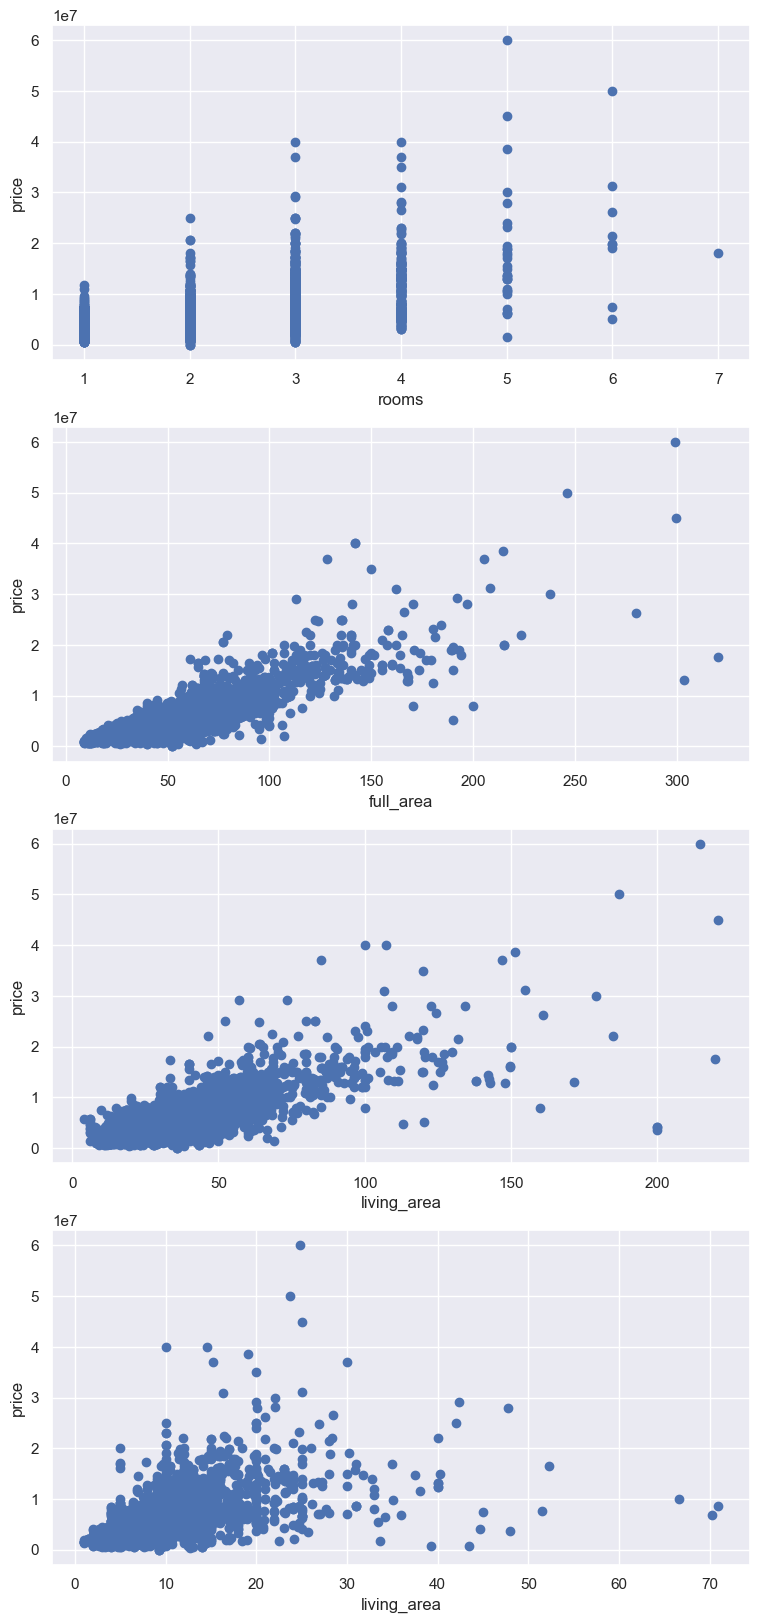

In [59]:
#Посмотрим наличие зависимостей между price и численными параметрами квартиры

sns.set()
fig,(ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(9, 20))

ax1.scatter(x=dataset.rooms, y=dataset.price)
ax1.set_xlabel('rooms')
ax1.set_ylabel('price')
ax2.scatter(x=dataset.full_area, y=dataset.price)
ax2.set_xlabel('full_area')
ax2.set_ylabel('price')
ax3.scatter(x=dataset.living_area, y=dataset.price)
ax3.set_xlabel('living_area')
ax3.set_ylabel('price')
ax4.scatter(x=dataset.kitchen_area, y=dataset.price)
ax4.set_xlabel('living_area')
ax4.set_ylabel('price')

In [71]:
#Преобразуем категориальные признаки в численные для составления прогнозной модели

transformer = make_column_transformer(
(OneHotEncoder(), ['repair_type', 'bathroom_type', 'material_type', 'flat_type', 'balcony_type']), remainder = 'passthrough', verbose_feature_names_out=False)

transformed = transformer.fit_transform(dataset)
dataset_final = pd.DataFrame(transformed, columns = transformer.get_feature_names_out())
dataset_final

,repair_type_unknown,repair_type_в отличном состоянии,repair_type_в хорошем состоянии,repair_type_требуется ремонт,repair_type_черновая отделка,bathroom_type_unknown,bathroom_type_раздельный,bathroom_type_совмещенный,material_type_unknown,material_type_бетон,...,"balcony_type_балкон, остекление",balcony_type_лоджия,"balcony_type_лоджия, остекление",price,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,3300000.0,1.0,30.0,18.000000,6.000000,3.0,5.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8500000.0,2.0,58.7,49.940000,11.261538,6.0,19.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2000000.0,1.0,13.0,11.500000,4.000000,1.0,5.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,8100000.0,2.0,63.5,31.800000,9.400000,3.0,10.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,6600000.0,2.0,60.0,35.000000,25.000000,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2100000.0,2.0,27.0,24.000000,6.729942,6.0,9.0
5212,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1600000.0,2.0,37.7,25.375146,5.000000,5.0,5.0
5213,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,570000.0,3.0,64.0,43.216667,14.000000,1.0,1.0
5214,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4850000.0,3.0,58.0,41.000000,5.000000,5.0,5.0
